In [25]:
#2 Лабораторная работа
#Цель - познакомиться с методом кластеризации K-mean с помощью пакета sklearn. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
df = pd.read_csv('D:\car_sales_data.csv')



In [26]:
#1) Добавление нового атрибута - Возраст автомобиля
current_year = 2025
df['Car_Age'] = current_year - df['Year of manufacture']

In [18]:
#2) Обработка данных
df = df.drop_duplicates()


df = df.copy()
df['Engine size'] = df['Engine size'].fillna(df['Engine size'].median())
df['Mileage'] = df['Mileage'].fillna(df['Mileage'].median())

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'Price')
df = remove_outliers_iqr(df, 'Mileage')
df = remove_outliers_iqr(df, 'Engine size')

le = LabelEncoder()
df['Fuel_type_encoded'] = le.fit_transform(df['Fuel type'])

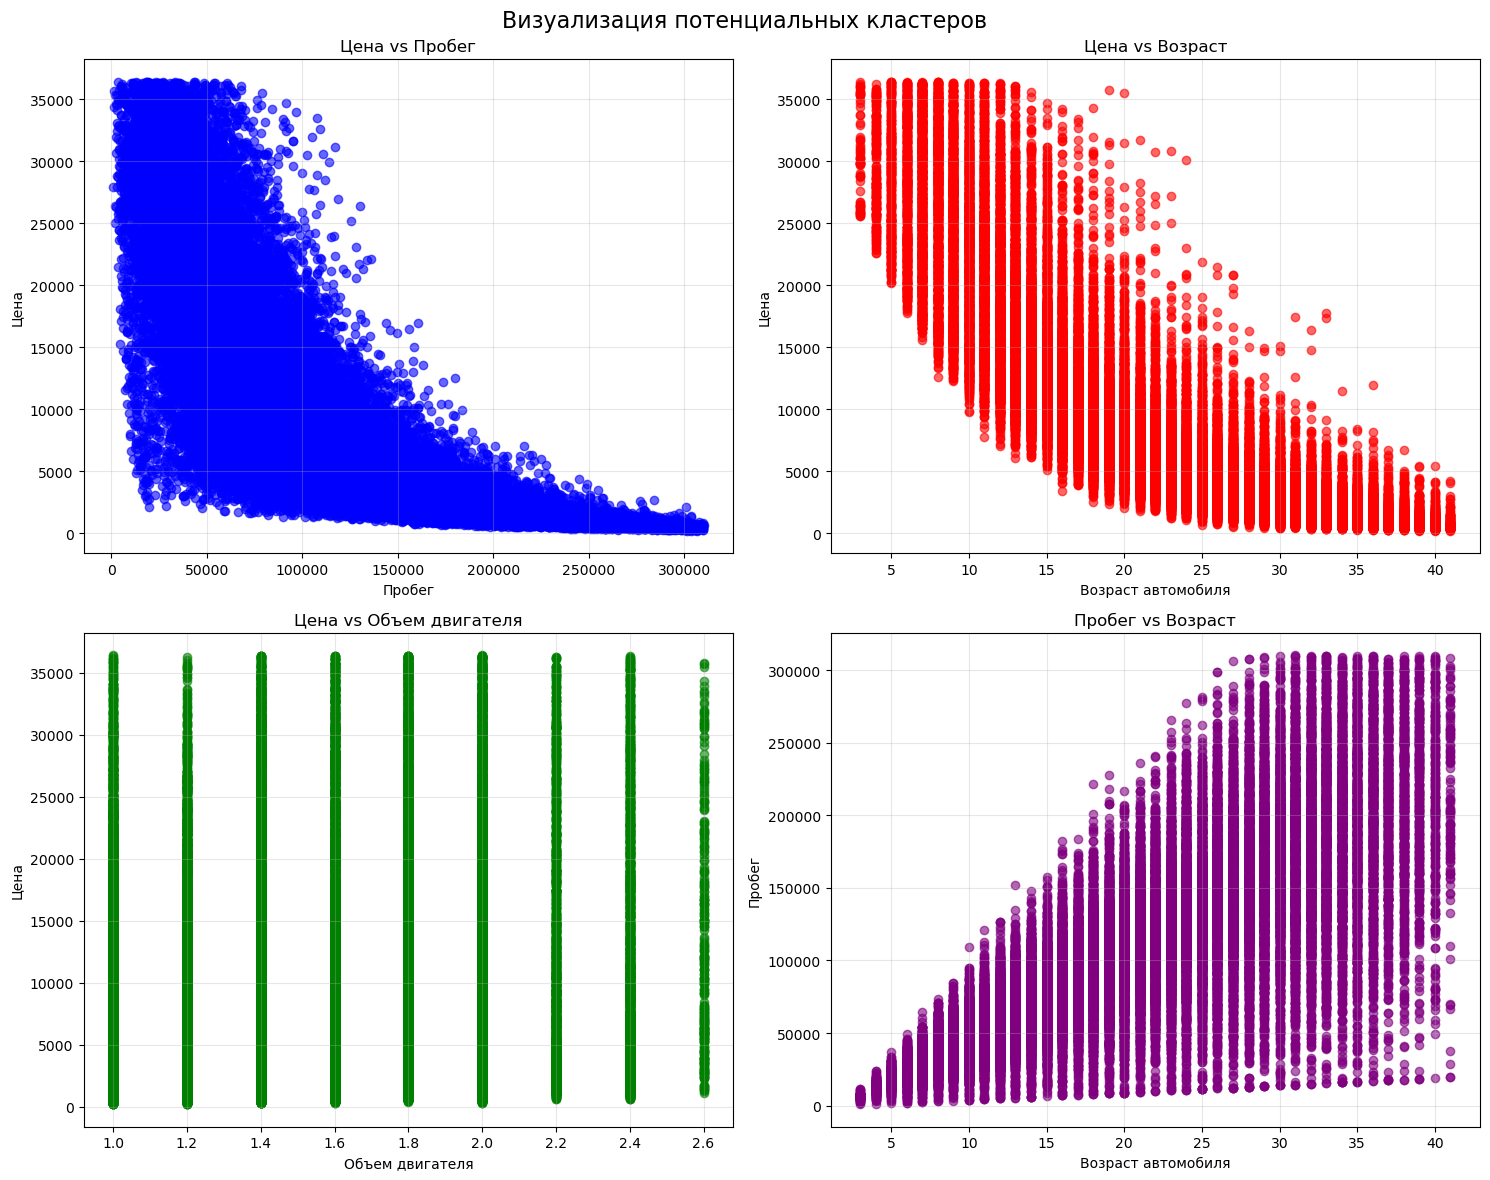

1й график. Видна обратная зависимость, чем больше пробег, тем ниже цена
2й график. Обратная зависимость, старые автомобили дешевле новых
3й график. От обьема двигателя цена очень слабо зависит
4й график. Прямая зависимость, Чем старше авто, тем больше пробег


In [21]:
#3) Визуалтзация и поиск кластеров

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Визуализация потенциальных кластеров', fontsize=16)

axes[0,0].scatter(df['Mileage'], df['Price'], alpha=0.6, color='blue')
axes[0,0].set_xlabel('Пробег')
axes[0,0].set_ylabel('Цена')
axes[0,0].set_title('Цена vs Пробег')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].scatter(df['Car_Age'], df['Price'], alpha=0.6, color='red')
axes[0,1].set_xlabel('Возраст автомобиля')
axes[0,1].set_ylabel('Цена')
axes[0,1].set_title('Цена vs Возраст')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].scatter(df['Engine size'], df['Price'], alpha=0.6, color='green')
axes[1,0].set_xlabel('Объем двигателя')
axes[1,0].set_ylabel('Цена')
axes[1,0].set_title('Цена vs Объем двигателя')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(df['Car_Age'], df['Mileage'], alpha=0.6, color='purple')
axes[1,1].set_xlabel('Возраст автомобиля')
axes[1,1].set_ylabel('Пробег')
axes[1,1].set_title('Пробег vs Возраст')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print('''1й график. Видна обратная зависимость, чем больше пробег, тем ниже цена
2й график. Обратная зависимость, старые автомобили дешевле новых
3й график. От обьема двигателя цена очень слабо зависит
4й график. Прямая зависимость, Чем старше авто, тем больше пробег''')


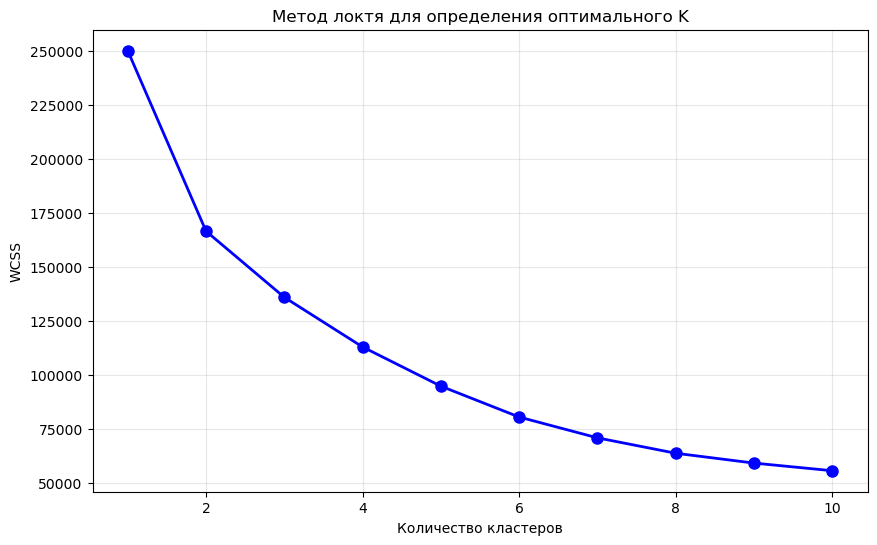

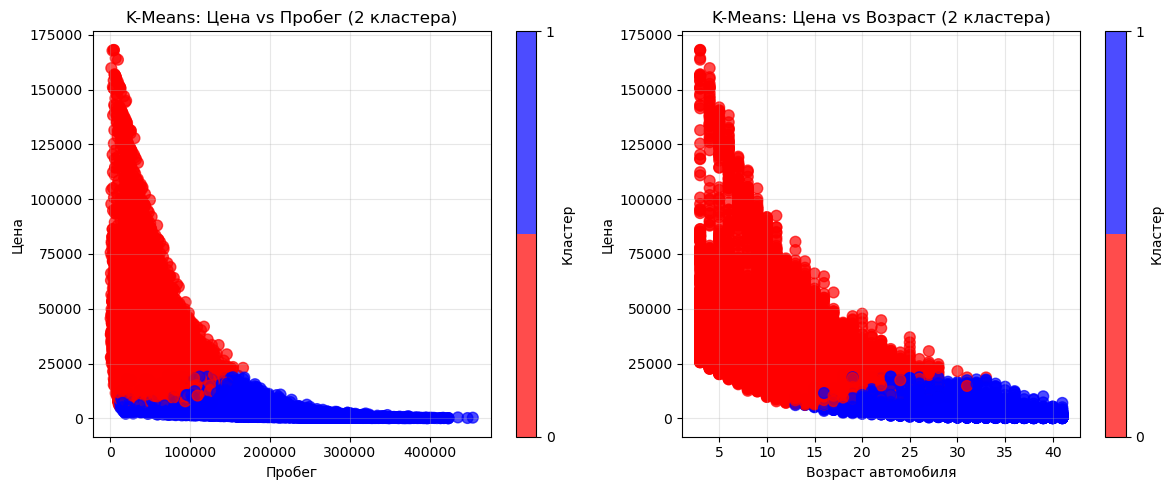

In [38]:
#4) Применение KMeans

features = ['Engine size', 'Car_Age', 'Mileage', 'Price', 'Fuel_type_encoded']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя для определения оптимального K')
plt.grid(True, alpha=0.3)
plt.show()


differences = [wcss[i] - wcss[i+1] for i in range(len(wcss)-1)]
optimal_k = differences.index(max(differences)) + 2


kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple'][:optimal_k]
scatter = plt.scatter(df['Mileage'], df['Price'], c=df['Cluster'], 
                     cmap=plt.cm.colors.ListedColormap(colors), alpha=0.7, s=60)
plt.xlabel('Пробег')
plt.ylabel('Цена')
plt.title(f'K-Means: Цена vs Пробег ({optimal_k} кластера)')
plt.colorbar(scatter, label='Кластер', ticks=range(optimal_k))
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(df['Car_Age'], df['Price'], c=df['Cluster'], 
                     cmap=plt.cm.colors.ListedColormap(colors), alpha=0.7, s=60)
plt.xlabel('Возраст автомобиля')
plt.ylabel('Цена')
plt.title(f'K-Means: Цена vs Возраст ({optimal_k} кластера)')
plt.colorbar(scatter, label='Кластер', ticks=range(optimal_k))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
print('''На графиках видна четкая обратная зависимость между ценой и возрастом/пробегом, 
Метод локтя показал оптимальное количество кластеров: 2
Выделились 2 сегмента:
   - Кластер 0: Средний и высокий класс (ср.цена: $20100, ср.возраст: 12.4 лет)
   - Кластер 1: Бюджетные автомобили (ср.цена: $3853, ср.возраст: 27.8 лет)''')

На графиках видна четкая обратная зависимость между ценой и возрастом/пробегом, 
Метод локтя показал оптимальное количество кластеров: 2
Выделились 2 сегмента:
   - Кластер 0: Средний и высокий класс (ср.цена: $20100, ср.возраст: 12.4 лет)
   - Кластер 1: Бюджетные автомобили (ср.цена: $3853, ср.возраст: 27.8 лет)
